In [1]:
import qutip
import numpy as np
import matplotlib.pyplot as plt

# Introduction
We shall be using qutrits to describe the three states involved in the controlled-z gates using a rydberg excited state $|r\rangle$ in addition to the hyperfine ground $|g\rangle$ and excited states $|e\rangle$ used for the digital basis. This corresponds to the following configuration of a three-level system:
<img src="files/three_states.png" alt="Three-state Configuration" style="width: 120px;"/>


# Basic Definitions

First we construct the basic states and operators:

In [2]:
# Three-state basis:
r = qutip.basis(3,0)
g = qutip.basis(3,1)
h = qutip.basis(3,2)

In [3]:
# Basic transition operators:
I = qutip.qeye(3)

sigma_gr = r*g.dag() + g*r.dag() + 0*h*h.dag()
rydY = -1j*r*g.dag() + 1j*g*r.dag() + 0*h*h.dag()
rydZ = r*r.dag() - g*g.dag() 

sigma_hg = h*g.dag() + g*h.dag() + 0*r*r.dag()
excY = 1j*h*g.dag() - 1j*g*h.dag() + 0*r*r.dag()
excZ = -h*h.dag() + g*g.dag() 

sigma_rr = r*r.dag()
sigma_gg = g*g.dag()
sigma_hh = h*h.dag()

Check that these definitions work well

In [4]:
print(sigma_gr * g) # Gives rydberg
print(sigma_hg * g) # Gives excited
print(sigma_gr * r) # Gives ground
print(sigma_gr * h) # Transition does not take place
print(sigma_hg * r) # Transition does not take place

Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]]
Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [1.]]
Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[0.]
 [1.]
 [0.]]
Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]]
Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]]


# General Rotation
Let's construct a rotation operator on the qutrit, which represents the pulses acting in our three-level system. Each pulse is characterized by an amplitude $\Omega$ and frequency $\delta$ 

In [5]:
# Using Rotating Wave Approximation:
def ryd_rotate(amplitude, detuning, phase):
    return 0.5*(amplitude*np.cos(phase)*sigma_gr - amplitude*np.sin(phase)*rydY + detuning*rydZ)

def dig_rotate(amplitude, detuning, phase):
    return 0.5*(amplitude*np.cos(phase)*sigma_hg - amplitude*np.sin(phase)*excY + detuning*excZ)

# Rabi Oscillations
Let's first verify that the Rabi oscillation between both types of excited levels and the ground state work:

In [6]:
times = np.linspace(0,np.pi,60)

In [7]:
H = ryd_rotate(1,0,0) # Rotation along the X axis. Ground-Rydberg basis.
observables = [sigma_rr, sigma_gg, sigma_hh]
evolution = qutip.sesolve(H, g, times, observables)

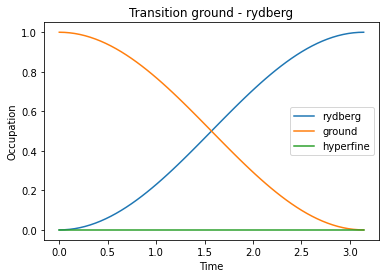

In [8]:
names=['rydberg','ground','hyperfine']
for i,results in enumerate(evolution.expect):
    plt.plot(times,results,label=f"{names[i]}")

plt.ylabel('Occupation')
plt.xlabel('Time')
plt.title('Transition ground - rydberg')
plt.legend()

If we instead evolve with a digital-basis rotation:

In [9]:
H = dig_rotate(1,0,0) # Rotation along the X axis. Ground-Rydberg basis.
evolution = qutip.sesolve(H, g, times, observables)

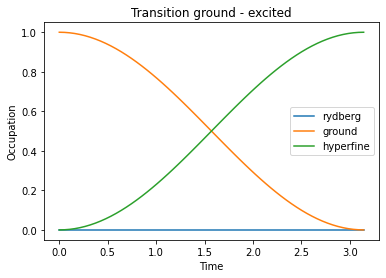

In [10]:
for i,results in enumerate(evolution.expect):
    plt.plot(times,results,label=f"{names[i]}")

plt.ylabel('Occupation')
plt.xlabel('Time')
plt.title('Transition ground - excited')
plt.legend()

Let's see the effect of the magnetization operators

In [11]:
H = ryd_rotate(1,0,0) # Rotation along the X axis. Digital basis.
evolution = qutip.sesolve(H, g, times, [rydZ,excZ])

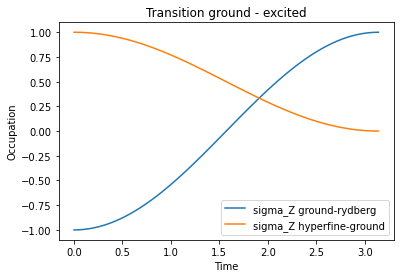

In [12]:
names = ['sigma_Z ground-rydberg','sigma_Z hyperfine-ground']
for i,results in enumerate(evolution.expect):
    plt.plot(times,results,label=f"{names[i]}")

plt.ylabel('Occupation')
plt.xlabel('Time')
plt.title('Transition ground - excited')
plt.legend()

# Two Atom System
Now we consider two atoms: one for control and one for the target of a Control-Z gate. They will also interact via a Van der Waals coupling, which will depend on the physical distance between the two qutrits

In [13]:
gg = qutip.tensor([g,g])

gh = qutip.tensor([g,h])
hg = qutip.tensor([h,g])
hh = qutip.tensor([h,h])

gr = qutip.tensor([g,r])
rg = qutip.tensor([r,g])
rr = qutip.tensor([r,r])

hr = qutip.tensor([h,r])
rh = qutip.tensor([r,h])

# Rydberg Blockade

If one of the atoms is in the ground state while the other one is in the rydberg state, we observe a blockade effect

In [14]:
#Define Operators

VdW = qutip.tensor([sigma_rr,sigma_rr])
rotation = qutip.tensor([ryd_rotate(1,0,0),I]) #Rotation in the Ground-Rydberg basis
observables = [qutip.tensor([sigma_gg,sigma_rr]),qutip.tensor([sigma_rr,sigma_rr])]

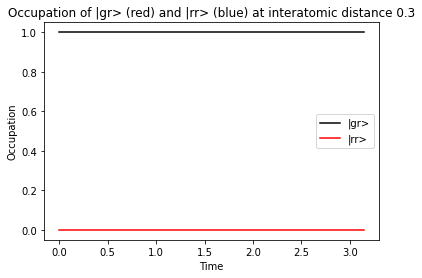

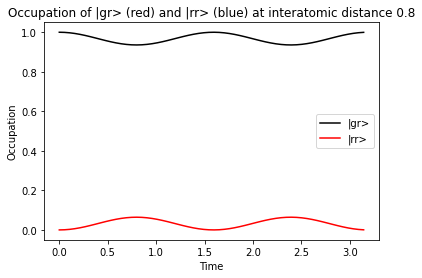

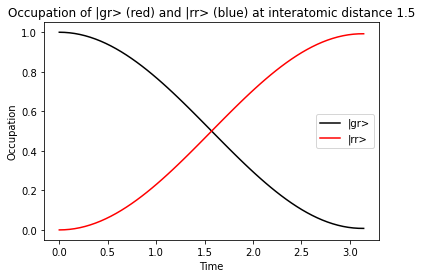

In [15]:
# Try different distances bewteen atoms:
for R in [0.3, 0.8, 1.5]:
    #print(1/R**6)
    
    H = (1/R**6)*VdW + rotation
    evolution = qutip.sesolve(H, gr, times, observables) # Rotates the first atom around the x axis
    
    plt.plot(evolution.times, evolution.expect[0],label='|gr>',color='black')
    plt.plot(evolution.times, evolution.expect[1],label='|rr>',color='red')
    
    plt.ylabel('Occupation')
    plt.xlabel('Time')
    plt.title(f'Occupation of |gr> (red) and |rr> (blue) at interatomic distance {R}')
    plt.legend()
    plt.show()

Notice how the population transfer from $|gr\rangle$ is blocked when R is below the rydberg blockade radius. Correspondingly, the $|rr\rangle$ state becomes occupied when we are above the blockade radius. 

A different outcome results if we start from the $|gg\rangle$ state and rotate *simultaneously* both atoms. In that case, we obtain the entangled state $(|rg\rangle + |gr\rangle)/\sqrt{2}$:

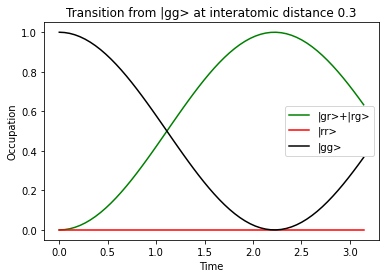

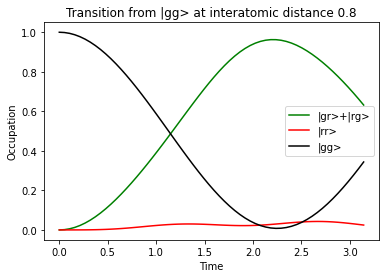

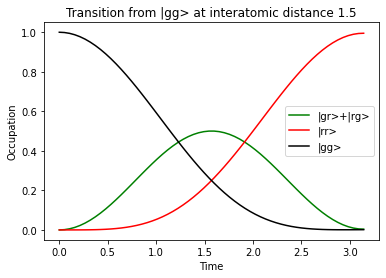

In [16]:
# Evolve both atoms simultaneously
rotation = qutip.tensor([ryd_rotate(1,0,0),I]) + qutip.tensor([I,ryd_rotate(1,0,0)]) 
observables = [(qutip.tensor([sigma_gg,sigma_rr])+qutip.tensor([sigma_rr,sigma_gg])),
              qutip.tensor([sigma_rr,sigma_rr]),
              qutip.tensor([sigma_gg,sigma_gg])]

# Try different distances bewteen atoms:
for R in [0.3, 0.8, 1.5]:
    #print(1/R**6)
    
    H = (1/R**6)*VdW + rotation
    evolution = qutip.sesolve(H, gg, times, observables) # Rotates the first atom around the x axis
    
    plt.plot(evolution.times, evolution.expect[0],label=f'|gr>+|rg>',color='green')
    plt.plot(evolution.times, evolution.expect[1],label=f'|rr>',color='red')
    plt.plot(evolution.times, evolution.expect[2],label=f'|gg>',color='black')
    
    plt.ylabel('Occupation')
    plt.xlabel('Time')
    plt.title(f'Transition from |gg> at interatomic distance {R}')
    plt.legend()
    plt.show()

# Controlled-Z gate
Now we construct the series of pulses that implement the CZ gate as a sequence. We store the intermediate state after each step

In [17]:
def CZ(initial,distances=np.linspace(0.26,1.7,100),plots=False):
    """
    Implements the CZ gate pulse sequence. A range of distances between the atoms
    is automatically given but one can give specific values as parameters.
    Notice that the time steps are defined automatically
    """
    times = np.linspace(0,np.pi,40)
    
    control_rotation = qutip.tensor([ryd_rotate(1,0,0),I]) #Rotation in the Ground-Rydberg basis
    target_rotation = qutip.tensor([I,ryd_rotate(2,0,0)]) #Rotation in the Ground-Rydberg basis

    sequence = {
        "pi pulse control": control_rotation,
        "2pi pulse target": target_rotation, 
        "pi pulse control(again)": control_rotation
        }
    
    evolution_r =[]
    evolution_i =[]
    
    for R in distances:

        state = initial # set initial state
        for x in sequence:

            H = (1/R**6)*VdW + sequence[x] 
            result = qutip.sesolve(H, state, times) # Without observables, we get the output state
            state = result.states[-1]

        scalar_prod = np.vdot(initial.data.toarray(),state.data.toarray())
        evolution_r.append(np.real(scalar_prod))
        #evolution_i.append(np.imag(scalar_prod))
    
    if initial == gg: names = 'gg' 
    if initial == gh: names = 'gh' 
    if initial == hg: names = 'hg' 
    if initial == hh: names = 'hh' 
    
    if plots:
        plt.plot(distances,evolution_r, label=f"Re <{names}|psi_out>")
        #plt.plot(distances,evolution_i,label=f"Im <{names}|psi_out>")
        plt.title('Overlap with the initial state')
        plt.legend()
    
    return scalar_prod

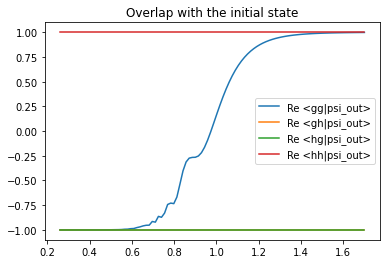

In [18]:
for initial in [gg,gh,hg,hh]:
    CZ(initial,plots=True)

Notice that the rydberg blockade acts only on the $|gg\rangle$ case, which corresponds to a "$|11\rangle$" state. If we place the atoms at $r<0.6$ we then get the following effective $CZ$ gate: 

In [19]:
for initial in [gg,gh,hg,hh]: #equivalent to 00,01,10,11
    print(CZ(initial,distances=[0.3]))

(-0.999997333027251-0.0022904781986179544j)
(-0.9999999998680958+0j)
(-0.9999999999652566+0j)
(1+0j)


# Fidelity of the gate

In [20]:
def fidelity(initial,expected,distances=np.linspace(0.26,0.61,200),plots=False,label=None):
    """
    Implements the CZ gate pulse sequence and calculates the fidelity with 
    respect to R/R_B, where R_B is the blockade radius.
    A range of distances between the atoms is automatically given but one can 
    give specific values as parameters. Notice that the time steps are defined automatically
    """
    times = np.linspace(0,np.pi,40)
    
    control_rotation = qutip.tensor([ryd_rotate(1,0,0),I]) #Rotation in the Ground-Rydberg basis
    target_rotation = qutip.tensor([I,ryd_rotate(2,0,0)]) #Rotation in the Ground-Rydberg basis

    sequence = {
        "pi pulse control": control_rotation,
        "2pi pulse target": target_rotation, 
        "pi pulse control(again)": control_rotation
        }
    
    fid =[]
    
    for R in distances:

        state = initial # set initial state
        for x in sequence:

            H = (1/R**6)*VdW + sequence[x] 
            result = qutip.sesolve(H, state, times) # Without observables, we get the output state
            state = result.states[-1]
        
        #overlap = np.vdot(expected.data.toarray(),state.data.toarray())
        #dm_initial = initial*initial.dag()
        #dm_expected = expected*expected.dag()
        #fid.append(np.abs(overlap)**2)
        fid.append(qutip.fidelity(state,expected))
        
    if plots:
        plt.plot(distances/0.6,fid,label=f"{label}")
        #plt.plot(distances,evolution_i,label=f"Im <initial|psi_out>")
        plt.title('Fidelity')
        plt.legend()
    
    #return scalar_prod

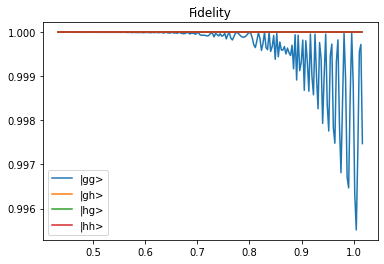

In [21]:
fidelity(gg,-gg,plots=True,label='|gg>')
fidelity(gh,gh,plots=True,label='|gh>')
fidelity(hg,hg,plots=True,label='|hg>')
fidelity(hh,hh,plots=True,label='|hh>')